In [103]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

In [104]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [106]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [107]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t

path ../datasets/drum_midi/50´s Drummer MIDI Files/05 Jazz/10 Scalis 190BPM 3-4
  01 8th Snare.mid
  02 8th hat.mid
  03 8th Toms.mid
  04 8th Toms.mid
  05 8th Multi.mid
  06 8th Snare.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/06 Soul - Funk
path ../datasets/drum_midi/50´s Drummer MIDI Files/06 Soul - Funk/01 Soul Groove 107BPM
  01 16th Hat.mid
  02 16th Hat.mid
  03 8th Hat.mid
  04 16th Hat.mid
  05 16th Hat.mid
  06 8th Hat.mid
  07 16th Hat.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/06 Soul - Funk/02 Boogaloo 120BPM
  01 16th Multi.mid
  02 4th Multi.mid
  03 16th Hat.mid
  04 4th Multi.mid
  05 8th Multi.mid
  06 16th Hat.mid
  07 8th Hat.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/06 Soul - Funk/03 Cadence Soul 105BPM
  01 4th Hat.mid
  02 4th Hat.mid
  03 8th Hat.mid
  04 4th Hat.mid
  05 4th Hat.mid
  06 8th Cym.mid
  07 8th Hat.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/06 Soul - Funk/04 GoGo Soul 100BPM
  01

In [108]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [109]:
# [(i,k) for i,k in enumerate(labels)]

In [110]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
"""Genre dict = for classes
Label dict = for unique samples
"""
genre_dict = setup.build_label_dict(genres[:m])
labels_ = [label.split('/') for label in labels]
label_dict = setup.build_label_dict(labels_)

In [111]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [112]:
latent_dim = 10
epsilon_std = 1.0
batch_size = 128
epochs = 500

name = 'non-functional_model.h5'
fn = config.model_dir + name

In [113]:
vae, encoder, generator = models.build(input_shape, latent_dim)
vae.load_weights(fn)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


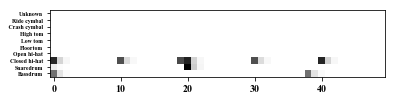

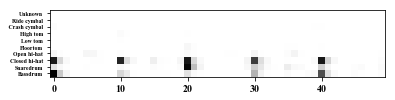

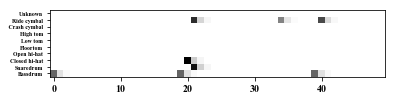

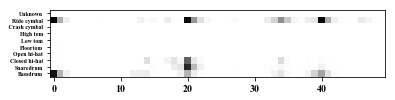

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [114]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

## NCD evaluation

In [115]:
dn = config.plots_dir
best_dims = io.load(dn + 'transformations-best_dims.pkl')
transformations = io.load(dn + 'transformations.pkl')
min_transformations = io.load(dn + 'min_transformations.pkl')

(array([317.,  80.,  69.,  21.,  51.,  67., 102.,  46.,  46., 188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

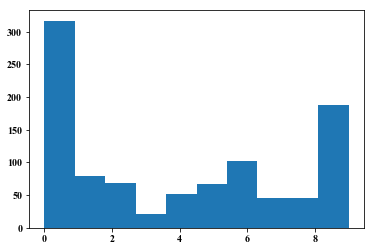

In [116]:
plt.hist(best_dims)

In [117]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [118]:
# utils.reload(ncd_evaluation)
grid = [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1, 0, -0.01, -0.1, -0.5, -1]
grid = np.linspace(0,1, 21)
# grid = (np.logspace(0, 1, 10) -1) / 9
# grid = np.round(grid, 2)
amt1 = 100
grid

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [38]:
different_genre_a = True
result_min = ncd_evaluation.cross(x_train_encoded, genre_dict, min_transformations, 
                                  generator, grid, different_genre_a, amt1=amt1, amt2=1, v=1)


0
original genre: `03 Traditional Pop/04 Love 155BPM`
 genre_a `03 Traditional Pop/07 Lester Lee 133BPM`

1
original genre: `03 Traditional Pop/02 Frankies Girl 116BPM`
 genre_a `03 Traditional Pop/03 King Quiza 102BPM`

2
original genre: `01 Rock'n'Roll/05 Straight Line 136BPM`
 genre_a `02 Blues/04 Mickeys 212BPM 12-8`

3
original genre: `04 Country/08 Eddie Ed 111BPM`
 genre_a `04 Country/09 Broonze 122BPM`

4
original genre: `02 Blues/06 Vidar Vega 70BPM`
 genre_a `04 Country/05 Brewer 160BPM`

5
original genre: `05 Jazz/01 Amel 85BPM Brushes`
 genre_a `06 Soul - Funk/02 Boogaloo 120BPM`

6
original genre: `04 Country/04 Snarey 208BPM 3-4`
 genre_a `05 Jazz/10 Scalis 190BPM 3-4`

7
original genre: `05 Jazz/09 West Coast 152BPM Brushes`
 genre_a `06 Soul - Funk/05 Hip Hop 95BPM`

8
original genre: `02 Blues/04 Mickeys 212BPM 12-8`
 genre_a `04 Country/05 Brewer 160BPM`

9
original genre: `03 Traditional Pop/05 Your Eyes 80BPM`
 genre_a `03 Traditional Pop/09 Distel 155BPM`

10
orig


85
original genre: `01 Rock'n'Roll/09 Diddeley 185bpm`
 genre_a `06 Soul - Funk/06 JB Groove 115BPM`

86
original genre: `03 Traditional Pop/10 Frewild 152BPM`
 genre_a `01 Rock'n'Roll/03 Lips n Hips 152BPM`

87
original genre: `01 Rock'n'Roll/09 Diddeley 185bpm`
 genre_a `06 Soul - Funk/08 Rim Soul 90BPM`

88
original genre: `02 Blues/01 Booze 92BPM`
 genre_a `07 Indie/01 Rock Shuffle 130BPM`

89
original genre: `03 Traditional Pop/04 Love 155BPM`
 genre_a `03 Traditional Pop/02 Frankies Girl 116BPM`

90
original genre: `03 Traditional Pop/02 Frankies Girl 116BPM`
 genre_a `07 Indie/05 Halftime 71BPM`

91
original genre: `03 Traditional Pop/07 Lester Lee 133BPM`
 genre_a `02 Blues/03 Noton Bull 192BPM 12-8 Brushes`

92
original genre: `07 Indie/04 Titanic 97BPM`
 genre_a `04 Country/04 Snarey 208BPM 3-4`

93
original genre: `05 Jazz/02 Another You 170BPM`
 genre_a `02 Blues/07 Straight 88BPM`

94
original genre: `03 Traditional Pop/08 Cecil Cee 101BPM`
 genre_a `06 Soul - Funk/01 Sou

In [39]:
io.save(result_min, config.plots_dir + 'ncd_evaluation_ABC_min.pkl')

'../results/ncd_evaluation_ABC_min.pkl'

In [40]:
result = ncd_evaluation.cross(x_train_encoded, genre_dict, transformations, 
                              generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)

In [41]:
io.save(result, config.plots_dir + 'ncd_evaluation_ABC.pkl')

'../results/ncd_evaluation_ABC.pkl'

In [42]:
# utils.reload(ncd_evaluation)
different_genre_a = False
result_AB_min = ncd_evaluation.cross(x_train_encoded, genre_dict, min_transformations, 
                                     generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)

In [43]:
io.save(result_AB_min, config.plots_dir + 'ncd_evaluation_AB_min.pkl')

'../results/ncd_evaluation_AB_min.pkl'

In [44]:
different_genre_a = False
result_AB = ncd_evaluation.cross(x_train_encoded, genre_dict, transformations, 
                                 generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)

In [45]:
io.save(result_AB, config.plots_dir + 'ncd_evaluation_AB.pkl')

'../results/ncd_evaluation_AB.pkl'

### One to one transformations

In [119]:
dn = config.plots_dir
# best_dims = io.load(dn + 'transformations-one-to-one-best_dims.pkl')
transformations = io.load(dn + 'transformations-one-to-one.pkl')
min_transformations = io.load(dn + 'min_transformations-one-to-one.pkl')

In [121]:
utils.reload(ncd_evaluation)
different_genre_a = False
result = ncd_evaluation.cross(x_train_encoded, label_dict, min_transformations, 
                generator, grid, different_genre_a, amt1=amt1, amt2=1, v=1)
io.save(result, config.plots_dir + 'ncd_evaluation-one-to-one_AB_min.pkl')


0
original genre: `10 Chilled 120BPM/02 8th Hat.mid`
 genre_a `10 Chilled 120BPM/02 8th Hat.mid`

1
original genre: `09 Smooth Soul 81BPM/04 16th Hat.mid`
 genre_a `09 Smooth Soul 81BPM/04 16th Hat.mid`

2
original genre: `03 Moon 137BPM/04 2th Toms.mid`
 genre_a `03 Moon 137BPM/04 2th Toms.mid`

3
original genre: `04 Titanic 97BPM/06 8th Toms.mid`

4
original genre: `09 Slow Shuffle 80BPM/06 8th Toms.mid`
 genre_a `09 Slow Shuffle 80BPM/06 8th Toms.mid`

5
original genre: `02 Nappy Brown 160BPM/02 8th Ride.mid`
 genre_a `02 Nappy Brown 160BPM/02 8th Ride.mid`

6
original genre: `06 JB Groove 115BPM/01 4th Hat.mid`

7
original genre: `03 Lips n Hips 152BPM/06 8th Hat.mid`
 genre_a `03 Lips n Hips 152BPM/06 8th Hat.mid`

8
original genre: `10 Syncopated Ride 128BPM/05 16th Hat.mid`
 genre_a `10 Syncopated Ride 128BPM/05 16th Hat.mid`

9
original genre: `01 Rock Shuffle 130BPM/01 8th Toms.mid`
 genre_a `01 Rock Shuffle 130BPM/01 8th Toms.mid`

10
original genre: `03 King Quiza 102BPM/04


86
original genre: `07 Trainy 100BPM/06 16th Perc.mid`
 genre_a `07 Trainy 100BPM/06 16th Perc.mid`

87
original genre: `03 Cool 137BPM Brushes/07 16th Ride.mid`
 genre_a `03 Cool 137BPM Brushes/07 16th Ride.mid`

88
original genre: `08 Sams 127BPM/07 8th Perc.mid`

89
original genre: `10 Frewild 152BPM/04 16th Ride.mid`
 genre_a `10 Frewild 152BPM/04 16th Ride.mid`

90
original genre: `10 Ottis 172bpm/05 8th Toms.mid`
 genre_a `10 Ottis 172bpm/05 8th Toms.mid`

91
original genre: `08 Eddie Ed 111BPM/06 8th Perc.mid`
 genre_a `08 Eddie Ed 111BPM/06 8th Perc.mid`

92
original genre: `08 Sams 127BPM/05 8th Perc.mid`
 genre_a `08 Sams 127BPM/05 8th Perc.mid`

93
original genre: `09 Slow Shuffle 80BPM/01 4th Toms.mid`
 genre_a `09 Slow Shuffle 80BPM/01 4th Toms.mid`

94
original genre: `09 Smooth Soul 81BPM/04 16th Hat.mid`
 genre_a `09 Smooth Soul 81BPM/04 16th Hat.mid`

95
original genre: `05 Halftime 71BPM/04 16th Cym.mid`
 genre_a `05 Halftime 71BPM/04 16th Cym.mid`

96
original genre

'../results/ncd_evaluation-one-to-one_AB_min.pkl'

In [122]:
result = ncd_evaluation.cross(x_train_encoded, label_dict, transformations, 
            generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)
io.save(result, config.plots_dir + 'ncd_evaluation-one-to-one_AB.pkl')

'../results/ncd_evaluation-one-to-one_AB.pkl'